In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from keras import backend as k
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications import Xception

In [2]:
birds = pd.read_csv('../data/birds.csv')

In [3]:
birds.head(5)

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [4]:
train = birds[birds['data set'] == 'train']
test = birds[birds['data set'] == 'test']
val = birds[birds['data set'] == 'valid']

In [5]:
train.shape

(54652, 4)

In [6]:
test.shape

(1875, 4)

In [7]:
val.shape

(1875, 4)

In [8]:
BATCH_SIZE = 34
EPOCHS = 50

In [32]:
datagen=ImageDataGenerator(rescale=1.0/255.0, 
                           shear_range=0.1, 
                           zoom_range=0.1, 
                           horizontal_flip=True, 
                           vertical_flip = True)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory="../data/",
    x_col="filepaths",
    y_col="labels",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128, 128),
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.1, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True, 
                                   vertical_flip = True)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val,
    directory="../data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128, 128),
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="../data/",
    x_col="filepaths",
    y_col=None,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(128, 128),
)

Found 54652 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames.


In [10]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs...
checkpoint = ModelCheckpoint(filepath="../models/resnet.h5", verbose=2, save_best_only=True)
vgg_checkpoint = ModelCheckpoint(filepath="../models/vgg16.h5", verbose=2, save_best_only=True)
incepV3_checkpoint = ModelCheckpoint(filepath="../models/inception.h5", verbose=2, save_best_only=True)
xcep_checkpoint = ModelCheckpoint(filepath="../models/Xception.h5", verbose=2, save_best_only=True)


# EarlyStopping callback is used to stop the training when accuracy doesn't improve for 5 epochs...
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

callbacks = [early_stop, checkpoint]
vgg_callbacks = [early_stop, vgg_checkpoint]
incepV3_callbacks = [early_stop, incepV3_checkpoint]
xcep_callbacks = [early_stop, xcep_checkpoint]

In [11]:
def plotter(history, model):
    fig, axes = plt.subplots(1, 2, figsize = (10, 5)) # fig of 1 row and 2 cols with 10x5 size...
    # In First column of figure, plotting accuracy and val accuracy from trained model object(history)...
    axes[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy') 
    axes[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
    axes[0].set_xlabel('Epochs', fontsize = 14)
    axes[0].set_ylabel('Accuracy',fontsize = 14)
    axes[0].set_title(f"{model} Accuracy Training vs Testing", fontsize = 14)
    axes[0].legend(loc = 'best') # Location of the legend, whereever is more empty space put legent there (loc= 'best')...
    # In Second column of figure, plotting accuracy and val accuracy from trained model object(history)...
    axes[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
    axes[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
    axes[1].set_xlabel('Epochs', fontsize = 14)
    axes[1].set_ylabel('Loss',fontsize = 14)
    axes[1].set_title(f"{model} Loss Training vs Testing", fontsize = 14)
    axes[1].legend(loc = 'best')
    plt.show()

In [12]:
# input of size 256x256x3... hight x width = 256 x 256, number of channels = 3...
input = Input(name = 'img_input', shape=(256, 256, 3))

In [13]:
# def network(base_model, input):
    
#     # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...
#     tf.keras.backend.clear_session() 

#     # Making Base model layers as non-trainable...
#     for layer in base_model.layers:
#       layer.trainable = False

#     input_layer = base_model(input) # defining input layer...


#     # Functional API of keras is used for this network...

#     # Convolution layer with 32 filters of size 3x3 and stride = 1x1, activation function used is ReLU and "valid" padding to keep the input and output size same...
#     # he normal kernel initializer is used as it performs well with non-linear activation functions like ReLU... 
#     conv = Conv2D(filters = 32, kernel_size = (7, 7), strides = (1, 1), padding = 'valid', activation = 'relu', 
#               kernel_initializer = tf.keras.initializers.he_normal())(input_layer)
#     pool = GlobalAveragePooling2D()(conv) # the pool size is set to the input size and it outputs the average of the pool...
#     d1 = Dense(units = 64, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal())(pool)
#     drop1 = Dropout(0.5)(d1) # dropout was used to deactivate some of the nodes to avoid overfitting...
#     d2 = Dense(units = 128, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal())(drop1)
#     bn = BatchNormalization()(d2) # batch normalization was used normalize weights batch wise and in turn reduce the chances of overfitting...
#     drop2 = Dropout(0.2)(bn)
#     d3 = Dense(units = 64, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal())(drop2)
#     Out = Dense(units = 375, activation = 'softmax', kernel_initializer = tf.keras.initializers.he_normal())(d3)
#     model = tf.keras.Model(input, Out) 
    
#     return model

In [30]:
def network(base_model, input):
    
    # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...
    tf.keras.backend.clear_session() 

    # Making Base model layers as non-trainable...
    for layer in base_model.layers:
      layer.trainable = False

    input_layer = base_model(input) # defining input layer...


    # Functional API of keras is used for this network...

    # Convolution layer with 32 filters of size 3x3 and stride = 1x1, activation function used is ReLU and "valid" padding to keep the input and output size same...
    # he normal kernel initializer is used as it performs well with non-linear activation functions like ReLU... 
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1, 1), padding = 'valid', activation = 'relu', 
              kernel_initializer = tf.keras.initializers.he_normal()))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal()))
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal()))
    model.add(Dense(units = 375, activation = 'softmax', kernel_initializer = tf.keras.initializers.he_normal()))
    
    return model

In [14]:
# k = 4
# num_val_samples = len(train) // k
# num_epochs = 100
# all_scores = []

# for i in range(k):
#     print(f'Processing Fold #{i}')
#     val_data = train[i * num_val_samples: (i+1) * num_val_samples]
#     part_x_data = np.concatenate([train[: i*num_val_samples], train[(i+1)*num_val_samples:]], axis = 0)
    
#     part_x_data = pd.DataFrame(part_x_data)
#     part_x_data.columns = ['class index', 'filepaths', 'labels', 'data set']
#     print(part_x_data.head(5))
#     # Loading weights of the ResNet101 pre-trained model without including top layers... imagenet is a dataset on which ResNet101 was trained...
#     resnet_model = ResNet101(input_tensor = input, include_top=False, weights="imagenet")

#     res_model = network(resnet_model, input)

#     adam = Adam(learning_rate=0.001) # ADAM optimizer was used to reach the optimal weights...
#     res_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
#     train_generator, valid_generator = data_generator(part_x_data, val_data)
    
#     # Fitting/training model...
#     res_history = res_model.fit(
#         train_generator, 
#         steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
#         callbacks=callbacks,
#         epochs = num_epochs, 
#         validation_data = valid_generator)

In [15]:
# Loading weights of the ResNet101 pre-trained model without including top layers... imagenet is a dataset on which ResNet101 was trained...
resnet_model = ResNet101(input_tensor = input, include_top=False, weights="imagenet")

res_model = network(resnet_model, input)

adam = Adam(learning_rate=0.001) # ADAM optimizer was used to reach the optimal weights...
res_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


# Fitting/training model...
res_history = res_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=callbacks,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/100
3416/3415 [==============================] - ETA: 0s - loss: 6.0036 - accuracy: 0.0034
Epoch 00001: val_loss improved from inf to 5.92939, saving model to ../models\resnet.h5


c:\datascience\python\machine_learning\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3415/3415 [==============================] - 727s 210ms/step - loss: 6.0036 - accuracy: 0.0034 - val_loss: 5.9294 - val_accuracy: 0.0027
Epoch 2/100
3416/3415 [==============================] - ETA: 0s - loss: 5.9212 - accuracy: 0.0043
Epoch 00002: val_loss did not improve from 5.92939
3415/3415 [==============================] - 557s 163ms/step - loss: 5.9212 - accuracy: 0.0043 - val_loss: 5.9327 - val_accuracy: 0.0027
Epoch 3/100
3416/3415 [==============================] - ETA: 0s - loss: 5.9189 - accuracy: 0.0045
Epoch 00003: val_loss did not improve from 5.92939
3415/3415 [==============================] - 559s 164ms/step - loss: 5.9189 - accuracy: 0.0045 - val_loss: 5.9351 - val_accuracy: 0.0027
Epoch 4/100
3416/3415 [==============================] - ETA: 0s - loss: 5.9183 - accuracy: 0.0045
Epoch 00004: val_loss did not improve from 5.92939
3415/3415 [==============================] - 559s 164ms/step - loss: 5.9183 - accuracy: 0.0045 - val_loss: 5.9364 - val_accuracy: 0.0027
Ep

KeyboardInterrupt: 

In [16]:
plotter(res_history, "ResNet101")

NameError: name 'res_history' is not defined

In [ ]:
# Loading weights of the vgg16 pre-trained model without including top layers... imagenet is a dataset on which vgg16 was trained...
vgg16_model = VGG16(input_tensor = input, include_top=False, weights="imagenet")

vgg_model = network(vgg16_model)

adam = Adam(learning_rate=0.001) # ADAM optimizer was used to reach the optimal weights...
vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


# Fitting/training model...
vgg_history = vgg_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=vgg_checkpoint,
    epochs = EPOCHS, 
    validation_data = valid_generator)

In [ ]:
plotter(vgg_history, "VGG16")

In [ ]:
vgg_results = vgg_model.evaluate(test_generator)
print(f"Accuracy of Inception v3 transfer learning model is: {vgg_results}")

In [1]:
# Loading weights of the InceptionV3 pre-trained model without including top layers... imagenet is a dataset on which InceptionV3 was trained...
inception_model = InceptionV3(input_tensor = input, include_top=False, weights="imagenet")

incepV3_model = network(inception_model, input)

adam = Adam(learning_rate=0.001) # ADAM optimizer was used to reach the optimal weights...
incepV3_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


# Fitting/training model...
incepV3_history = incepV3_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=incepV3_checkpoint,
    epochs = 50, 
    validation_data = valid_generator)

NameError: name 'InceptionV3' is not defined

In [ ]:
plotter(incepV3_history, "InceptionV3")

In [ ]:
incepV3_results = incepV3_model.evaluate(test_generator)
print(f"Accuracy of Inception v3 transfer learning model is: {incepV3_results}")

In [24]:
# base_model = EfficientNetB0(include_top=False)
base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
base_model.trainable=False


input_layer = base_model(input, training=False)

Xception_model = Sequential()
Xception_model.add(base_model)

Xception_model.add(Flatten()) 
Xception_model.add(Activation('relu'))
Xception_model.add(Dense(375)) 
Xception_model.add(Activation('softmax'))

# pool = Flatten()(input_layer)
# outputs = Dense(375, activation='softmax', dtype=tf.float32, name="Output_layer")(pool)

# Xception_model = Model(input, outputs,name="model")

In [25]:
adam = Adam(learning_rate=0.001) # ADAM optimizer was used to reach the optimal weights...
Xception_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


# Fitting/training model...
Xception_history = Xception_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=eff_callbacks,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/100
3416/3415 [==============================] - ETA: 0s - loss: 37.1840 - accuracy: 0.4592
Epoch 00001: val_loss improved from inf to 24.46029, saving model to ../models\efficient.h5
3415/3415 [==============================] - 579s 169ms/step - loss: 37.1840 - accuracy: 0.4592 - val_loss: 24.4603 - val_accuracy: 0.6469
Epoch 2/100
3416/3415 [==============================] - ETA: 0s - loss: 28.0520 - accuracy: 0.6665
Epoch 00002: val_loss improved from 24.46029 to 19.70260, saving model to ../models\efficient.h5
3415/3415 [==============================] - 550s 161ms/step - loss: 28.0520 - accuracy: 0.6665 - val_loss: 19.7026 - val_accuracy: 0.7493
Epoch 3/100
3416/3415 [==============================] - ETA: 0s - loss: 24.6238 - accuracy: 0.7315
Epoch 00003: val_loss improved from 19.70260 to 17.91088, saving model to ../models\efficient.h5
3415/3415 [==============================] - 543s 159ms/step - loss: 24.6238 - accuracy: 0.7315 - val_loss: 17.9109 - val_accuracy: 0.78

Epoch 29/100
3416/3415 [==============================] - ETA: 0s - loss: 6.6018 - accuracy: 0.9410
Epoch 00029: val_loss did not improve from 17.17629
3415/3415 [==============================] - 543s 159ms/step - loss: 6.6018 - accuracy: 0.9410 - val_loss: 21.4448 - val_accuracy: 0.8795
Epoch 30/100
3416/3415 [==============================] - ETA: 0s - loss: 6.1654 - accuracy: 0.9425
Epoch 00030: val_loss did not improve from 17.17629
3415/3415 [==============================] - 540s 158ms/step - loss: 6.1654 - accuracy: 0.9425 - val_loss: 20.8818 - val_accuracy: 0.8827
Epoch 31/100
3416/3415 [==============================] - ETA: 0s - loss: 6.0385 - accuracy: 0.9436
Epoch 00031: val_loss did not improve from 17.17629
3415/3415 [==============================] - 546s 160ms/step - loss: 6.0385 - accuracy: 0.9436 - val_loss: 19.3935 - val_accuracy: 0.8944
Epoch 32/100
3416/3415 [==============================] - ETA: 0s - loss: 6.0955 - accuracy: 0.9443
Epoch 00032: val_loss did not 

3416/3415 [==============================] - ETA: 0s - loss: 3.4952 - accuracy: 0.9677
Epoch 00057: val_loss did not improve from 17.17629
3415/3415 [==============================] - 629s 184ms/step - loss: 3.4952 - accuracy: 0.9677 - val_loss: 23.9286 - val_accuracy: 0.8949
Epoch 58/100
3416/3415 [==============================] - ETA: 0s - loss: 3.5849 - accuracy: 0.9685
Epoch 00058: val_loss did not improve from 17.17629
3415/3415 [==============================] - 619s 181ms/step - loss: 3.5849 - accuracy: 0.9685 - val_loss: 25.0468 - val_accuracy: 0.8901
Epoch 59/100
3416/3415 [==============================] - ETA: 0s - loss: 3.4610 - accuracy: 0.9683
Epoch 00059: val_loss did not improve from 17.17629
3415/3415 [==============================] - 637s 186ms/step - loss: 3.4610 - accuracy: 0.9683 - val_loss: 20.6938 - val_accuracy: 0.9008
Epoch 60/100
3416/3415 [==============================] - ETA: 0s - loss: 3.3579 - accuracy: 0.9697
Epoch 00060: val_loss did not improve from 

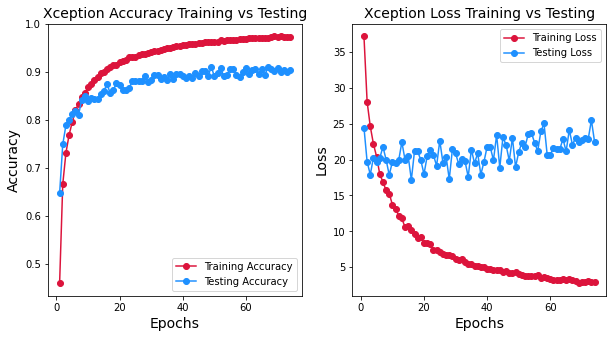

In [27]:
plotter(Xception_history, "Xception")